[Warning] GC missing for 31 rows (rna_id not found in FASTA).


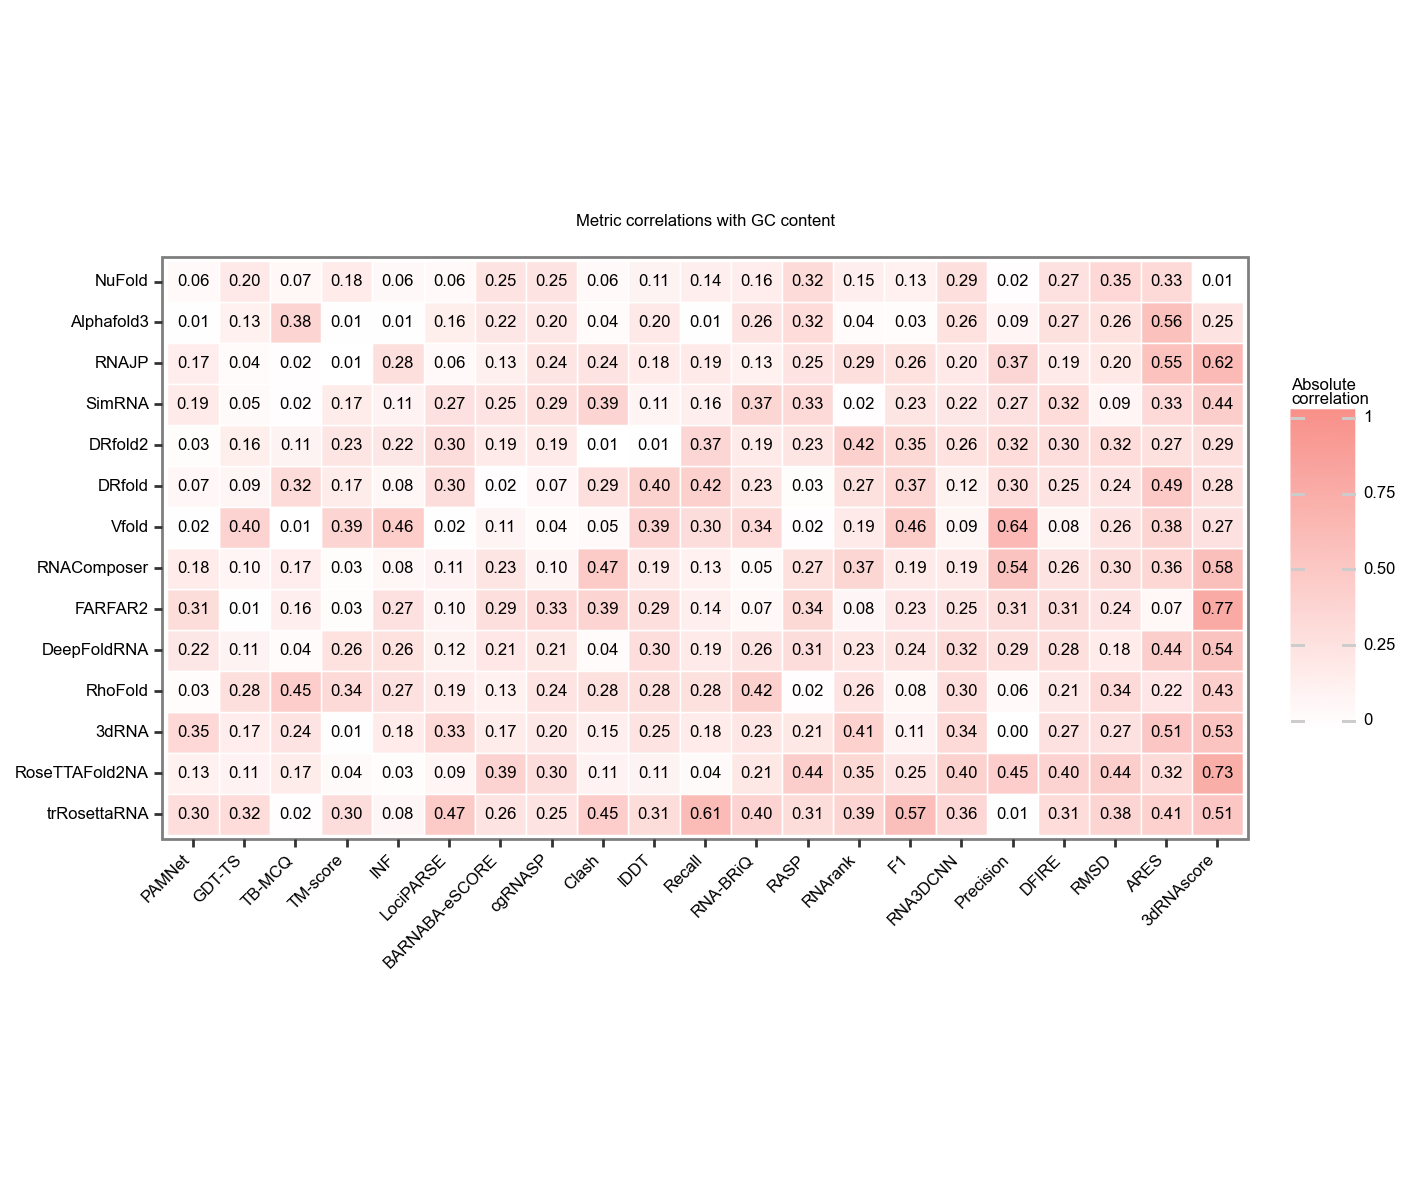

/home/wuyou/miniconda3/envs/sc/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 7.05 x 6 in image.
/home/wuyou/miniconda3/envs/sc/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../figures/metrics_correlation_GC.pdf


In [8]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""
Heatmap: absolute Pearson correlation between GC content and each evaluation metric,
computed separately for each prediction method.

Workflow:
1) Load and merge dataset1_merge.csv + dataset2_merge.csv
2) Parse FASTA files to compute GC% per RNA ID
3) Extract rna_id from df["rna"] and map GC% onto df
4) For each metric and method: trim outliers (IQR rule) then compute Pearson r(GC, metric)
5) Plot heatmap (plotnine) and save as vector PDF for publication

Python: 3.8
"""

from pathlib import Path
from typing import Dict, List, Tuple

import numpy as np
import pandas as pd
from scipy import stats
from Bio import SeqIO

from plotnine import (
    ggplot, aes, geom_tile, geom_text, theme_bw, theme,
    element_text, element_blank, labs, coord_fixed,
    scale_fill_gradient, guides
)


# -------------------------
# Configuration
# -------------------------
DATASET1_CSV = Path("../results/metrics/dataset1_merge.csv")
DATASET2_CSV = Path("../results/metrics/dataset2_merge.csv")

FASTA1 = Path("../datasets/dataset1/dataset1.fasta")
FASTA2 = Path("../datasets/dataset2/dataset2.fasta")

OUT_PDF = Path("../figures/metrics_correlation_GC.pdf")

FEATURES: List[str] = [
    "RMSD", "lddt", "TM-score", "GDT-TS", "LociPARSE", "RNArank",
    "INF-ALL", "f1", "precision", "recall",
    "BARNABA-eSCORE", "RNA3DCNN", "ARES", "tb_mcq", "PAMnet",
    "clash", "3drnascore", "RNA-BRiQ", "RASP-ENERGY", "DFIRE", "cgRNASP"
]

FEATURE_LABELS: Dict[str, str] = {
    "RMSD": "RMSD",
    "lddt": "lDDT",
    "TM-score": "TM-score",
    "GDT-TS": "GDT-TS",
    "LociPARSE": "LociPARSE",
    "RNArank": "RNArank",
    "INF-ALL": "INF",
    "f1": "F1",
    "precision": "Precision",
    "recall": "Recall",
    "BARNABA-eSCORE": "BARNABA-eSCORE",
    "RNA3DCNN": "RNA3DCNN",
    "ARES": "ARES",
    "tb_mcq": "TB-MCQ",
    "PAMnet": "PAMNet",
    "clash": "Clash",
    "3drnascore": "3dRNAscore",
    "RNA-BRiQ": "RNA-BRiQ",
    "RASP-ENERGY": "RASP",
    "DFIRE": "DFIRE",
    "cgRNASP": "cgRNASP"
}

# Outlier trimming per-metric: keep [Q1 - k*IQR, Q3 + k*IQR]
IQR_K = 5.0

# Plot style (small, clean, consistent)
FONT_FAMILY = "Arial"
FONT_SIZE = 6
FIGURE_SIZE_IN = (7.05, 6)  # inches
LABEL_FMT = "{:.2f}"        # tile number format


# -------------------------
# Utilities
# -------------------------
def require_columns(df: pd.DataFrame, cols: List[str]) -> None:
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required columns: {missing}")


def iqr_bounds(x: pd.Series, k: float = 5.0) -> Tuple[float, float]:
    q1 = x.quantile(0.25)
    q3 = x.quantile(0.75)
    iqr = q3 - q1
    return (q1 - k * iqr, q3 + k * iqr)


def safe_pearsonr(x: np.ndarray, y: np.ndarray) -> Tuple[float, float]:
    """Pearson r with edge-case handling (e.g., constant vectors)."""
    if x.size < 2 or y.size < 2:
        return (np.nan, np.nan)
    try:
        r, p = stats.pearsonr(x, y)
        return float(r), float(p)
    except Exception:
        return (np.nan, np.nan)


def gc_percent(seq: str) -> float:
    """GC% for an RNA sequence (G/C only, case-insensitive)."""
    s = seq.upper()
    if not s:
        return 0.0
    gc = s.count("G") + s.count("C")
    return 100.0 * gc / len(s)


def build_gc_dict(fasta_paths: List[Path]) -> Dict[str, float]:
    """
    Parse one or more FASTA files and return {record.id: GC%}.
    If duplicate IDs appear, later files overwrite earlier ones.
    """
    gc_map: Dict[str, float] = {}
    for fp in fasta_paths:
        if not fp.exists():
            raise FileNotFoundError(f"FASTA not found: {fp}")
        for rec in SeqIO.parse(str(fp), "fasta"):
            gc_map[rec.id] = gc_percent(str(rec.seq))
    return gc_map


def extract_rna_id(rna_field: str) -> str:
    """
    Extract rna_id from df['rna'].

    Your original rule:
        df["rna"].apply(lambda x: x.split(".")[2].split("_")[0])

    This function makes it explicit and slightly safer.
    """
    if not isinstance(rna_field, str):
        return ""
    parts = rna_field.split(".")
    if len(parts) < 3:
        return ""
    return parts[2].split("_")[0]


# -------------------------
# Core computation
# -------------------------
def compute_abs_corr_table(df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute abs Pearson correlation between GC and each metric, per method.
    Returns long-form table with:
        Method, Feature, abs_r, p, n
    """
    require_columns(df, ["method", "rna", "GC"] + FEATURES)

    # Reproducible method order (avoid set() randomness)
    methods = sorted(df["method"].dropna().unique().tolist())

    rows = []
    for feat in FEATURES:
        # Feature-specific outlier filtering across the whole dataset
        low, high = iqr_bounds(df[feat], k=IQR_K)

        df_feat = df.loc[
            (df[feat] >= low) & (df[feat] <= high),
            ["method", "GC", feat]
        ].dropna()

        for m in methods:
            sub = df_feat[df_feat["method"] == m]
            n = int(sub.shape[0])

            r, p = safe_pearsonr(sub["GC"].to_numpy(), sub[feat].to_numpy())
            rows.append({
                "Method": m,
                "Feature_raw": feat,
                "Feature": FEATURE_LABELS.get(feat, feat),
                "n": n,
                "r": r,
                "abs_r": np.abs(r) if np.isfinite(r) else np.nan,
                "p": p
            })

    out = pd.DataFrame(rows)

    # Reorder methods/features by mean abs correlation
    method_order = (out.groupby("Method")["abs_r"]
                    .mean()
                    .sort_values(ascending=False)
                    .index.tolist())
    feature_order = (out.groupby("Feature")["abs_r"]
                     .mean()
                     .sort_values(ascending=True)
                     .index.tolist())

    out["Method"] = pd.Categorical(out["Method"], categories=method_order, ordered=True)
    out["Feature"] = pd.Categorical(out["Feature"], categories=feature_order, ordered=True)

    # Tile label (avoid pandas operations inside aes)
    out["label"] = out["abs_r"].map(lambda v: "" if pd.isna(v) else LABEL_FMT.format(v))
    out.loc[out["n"] < 2, "label"] = ""

    return out


def plot_heatmap(heatmap_df: pd.DataFrame):
    """
    Publication-style heatmap (plotnine):
      fill = abs_r in [0,1]
      label = abs_r (two decimals)
    """
    p = (
        ggplot(heatmap_df, aes(x="Feature", y="Method", fill="abs_r"))
        + geom_tile(color="white", size=0.3)
        + geom_text(aes(label="label"), size=6, family=FONT_FAMILY, color="black")
        + scale_fill_gradient(
            low="white",
            high="#F89089",
            limits=[0, 1],
            name="Absolute\ncorrelation"
        )
        + theme_bw()
        + theme(
            figure_size=FIGURE_SIZE_IN,
            axis_text_x=element_text(
                rotation=45, hjust=1, size=FONT_SIZE, family=FONT_FAMILY, color="black"
            ),
            axis_text_y=element_text(
                size=FONT_SIZE, family=FONT_FAMILY, color="black"
            ),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            panel_grid=element_blank(),
            legend_title=element_text(size=FONT_SIZE, family=FONT_FAMILY),
            legend_text=element_text(size=FONT_SIZE, family=FONT_FAMILY),
            plot_title=element_text(hjust=0.5, size=FONT_SIZE, family=FONT_FAMILY, color="black"),
        )
        + labs(title="Metric correlations with GC content")
        + coord_fixed(ratio=0.8)
        #+ guides(fill=True)   # set to False if you want legend removed
    )
    return p


# -------------------------
# Main
# -------------------------
def main():
    # 1) Load metrics tables
    df1 = pd.read_csv(DATASET1_CSV, index_col=0)
    df2 = pd.read_csv(DATASET2_CSV, index_col=0)
    df = pd.concat([df1, df2], axis=0)

    # Basic requirements for downstream steps
    require_columns(df, ["method", "rna"] + FEATURES)

    # 2) Build GC% mapping from FASTA files
    gc_map = build_gc_dict([FASTA1, FASTA2])

    # 3) Extract rna_id and map GC
    df["rna_id"] = df["rna"].map(extract_rna_id)
    df["GC"] = df["rna_id"].map(gc_map)

    # Optional sanity checks (helpful for Methods)
    n_missing_gc = int(df["GC"].isna().sum())
    if n_missing_gc > 0:
        # Not raising, but printing is useful during figure generation
        print(f"[Warning] GC missing for {n_missing_gc} rows (rna_id not found in FASTA).")

    # 4) Compute abs correlations (GC vs metric) per method
    heatmap_df = compute_abs_corr_table(df)

    # 5) Plot and save (vector PDF)
    p = plot_heatmap(heatmap_df)
    print(p)

    OUT_PDF.parent.mkdir(parents=True, exist_ok=True)
    p.save(str(OUT_PDF), dpi=300)

    # Optional: export the underlying table for supplementary data
    # heatmap_df.to_csv("../results/metrics/abs_corr_gc_table.tsv", sep="\t", index=False)


if __name__ == "__main__":
    main()
